Class trader

Def analyze(lookback)
    Get data and coint pair
    Get optimal rolling window and entry exit

Def trade(period)
     Normal trades with position pnl etc

Def run(date range)
   Counter = 1
   For date in date
         trade
         Counter +=1
        If counter > n:
            Analyze, counter =0

In [59]:
import pandas as pd
import yfinance as yf
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [30]:
pair_1_tickers = ["MU","NVDA"]

start = dt.datetime(2024,6,1)
end = dt.datetime(2024,12,1)

pair_1_data = yf.download(pair_1_tickers, start, end)['Close']

[*********************100%***********************]  2 of 2 completed


In [451]:
pair_1_data

Ticker,MU,NVDA
Date,,
2024-06-03,127.581894,114.962219
2024-06-04,126.058907,116.398750
2024-06-05,133.096451,122.399780
2024-06-06,129.473175,120.958252
2024-06-07,130.339157,120.848289
...,...,...
2024-11-22,102.373528,141.927155
2024-11-25,104.208755,135.998123
2024-11-26,101.535706,136.897980


In [515]:
class pair_trading:
    def __init__(self,x_data,y_data,lookback=None,ZSCORE_ENTRY=None):
        self.x_data = x_data
        self.y_data = y_data
        self.lookback = None
        self.ZSCORE_ENTRY = ZSCORE_ENTRY
        self.spread = None
        self.z_scores = None
        self.positions = None
        self.beta = None # beta

    def compute_spread(self,lookback=None):
        x = self.x_data.iloc[:lookback] 
        y = self.y_data.iloc[:lookback]
        
        X = sm.add_constant(x)
        model = sm.OLS(y, X).fit()
        self.beta = model.params[1]
        self.spread = y - (intercept + self.beta*x)

        return self.spread
        
    def compute_z_score(self, rolling_window=None):
        rolling_mean = self.spread.rolling(window=rolling_window).mean()
        rolling_std = self.spread.rolling(window=rolling_window).std()
        self.z_scores = (self.spread - rolling_mean) / rolling_std
        return self.z_scores

    def generate_signals(self):
        df = pd.DataFrame({"z_scores":self.z_scores})
        df["z_signal"] = np.nan
        df.loc[df.z_scores<-self.ZSCORE_ENTRY, "z_signal"] =  1
        df.loc[df.z_scores>+self.ZSCORE_ENTRY, "z_signal"] =  -1
        
        df['positions'] = df.z_signal	
        df.loc[(df.z_scores.shift(1)*df.z_scores)<0,"positions"] = 0
        df["positions"] = df['positions'].ffill()
        df["BUY_or_SELL"] = df['positions'].fillna(0).diff().shift(1)
        return df

    def plot_signals(self, df):
        fig, axs = plt.subplots(2,1, figsize=(15,9), sharex=True)
        axs[0].plot(df.z_scores, label="Z-score")
        axs[0].axhline(0,color='red')
        axs[0].set_ylabel("Z Scores")
        axs[0].set_xlabel("Date")
        axs[0].legend()
        axs[0].grid(True)
        axs[0].plot(df.loc[df["BUY_or_SELL"] == -1].index, df.z_scores[df["BUY_or_SELL"] == -1], color='r', marker="v", linestyle='')
        axs[0].plot(df.loc[df["BUY_or_SELL"] == +1].index, df.z_scores[df["BUY_or_SELL"] == +1], color='g', marker="^", linestyle='')
        
        axs[1].plot(self.x_data, label="Asset x")
        axs[1].plot(self.y_data, label="Asset y")
        axs[1].legend()
        axs[1].grid(True)
        plt.show()

    def computePnL(self,df): #have not account for capital
        df["x_pnl"] = self.x_data*df["BUY_or_SELL"]*self.beta
        df["y_pnl"] = self.y_data*-df["BUY_or_SELL"]
        df['cumulative_pnl'] = (df['x_pnl'] + df['y_pnl']).cumsum()
        return df

In [516]:
y_data = pair_1_data["MU"]
x_data = pair_1_data["NVDA"]

C:\Users\lOvIn\AppData\Local\Temp\ipykernel_4268\822712937.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.beta = model.params[1]


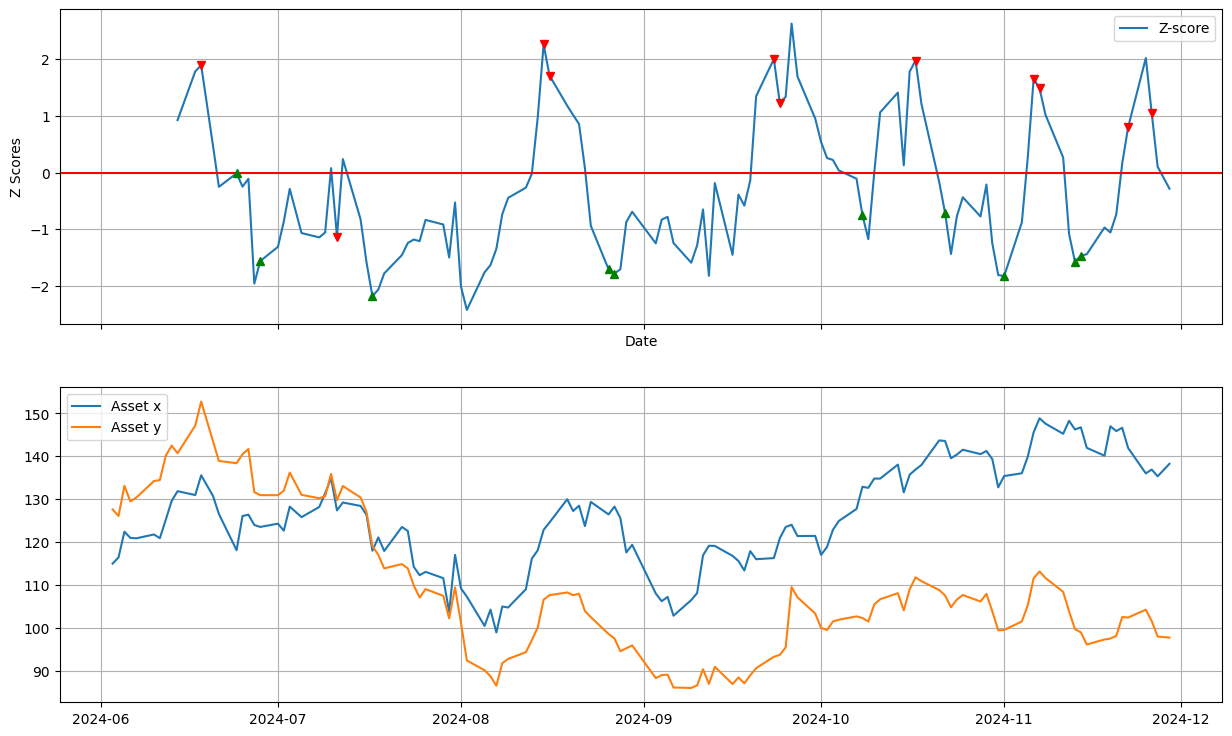

In [517]:
model = pair_trading(x_data, y_data, ZSCORE_ENTRY=1.5)
spread = model.compute_spread()
z_scores = model.compute_z_score(10)
df = model.generate_signals()
model.plot_signals(df)

In [518]:
model.computePnL(df)

,z_scores,z_signal,positions,BUY_or_SELL,x_pnl,y_pnl,cumulative_pnl
Date,,,,,,,
2024-06-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-05,NaN,NaN,NaN,0.0,0.000000,-0.000000,0.000000
2024-06-06,NaN,NaN,NaN,0.0,0.000000,-0.000000,0.000000
2024-06-07,NaN,NaN,NaN,0.0,0.000000,-0.000000,0.000000
...,...,...,...,...,...,...,...
2024-11-22,0.796910,NaN,0.0,-1.0,-44.563218,102.373528,29.524017
2024-11-25,2.018509,-1.0,-1.0,0.0,0.000000,-0.000000,29.524017
2024-11-26,1.049679,NaN,-1.0,-1.0,-42.984125,101.535706,88.075597
